## Kaggle - **Medical Cost Personal Datasets** 
EDA & Regression (Insurance Forecast by using Linear Regression)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/insurance.csv')

* 여러 환자의 치료 비용 데이터 세트 

치료 비용은 진단명, 진료소 유형, 거주 도시, 나이 등 많은 요인에 따라 달라집니다. 

우리는 환자의 진단명에 대한 데이터를 가지고 있지 않으나, 환자의 건강에 대한 결론을 내리고 회귀 분석을 실행하는 데 도움이 되는 다른 정보들을 갖고 있습니다.

그러면 먼저, 데이터를 살펴보겠습니다.

In [4]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


* age: age of primary beneficiary

* sex: insurance contractor gender, female, male

* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* children: Number of children covered by health insurance / Number of dependents

* smoker: Smoking

* region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

* charges: Individual medical costs billed by health insurance

In [5]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

* NaN 값이 없는 데이터

비용의 정도에 관심이 있기 때문에, 어떤 변수가 charges와 더 관련이 있는지 살펴봅니다. 

우선 categorical features를 인코딩하겠습니다.(sex, smoker, region)

In [6]:
from sklearn.preprocessing import LabelEncoder

# sex
le = LabelEncoder()
le.fit(data.sex.drop_duplicates()) 
data.sex = le.transform(data.sex)

# smoker or not
le.fit(data.smoker.drop_duplicates()) 
data.smoker = le.transform(data.smoker)

# region
le.fit(data.region.drop_duplicates()) 
data.region = le.transform(data.region)

일반적으로 변동성이 큰 범주형 변수는 OneHotEncoder 등을 사용하여 인코딩하는 것이 가장 좋습니다. 

그러나 이 경우에는 region이 나열되는 특별한 순서가 없기 때문에 아무것도 변경되지 않으므로 LabelEncoder만 사용하고 있습니다.

In [7]:
data.corr()['charges'].sort_values()

region     -0.006208
sex         0.057292
children    0.067998
bmi         0.198341
age         0.299008
smoker      0.787251
charges     1.000000
Name: charges, dtype: float64

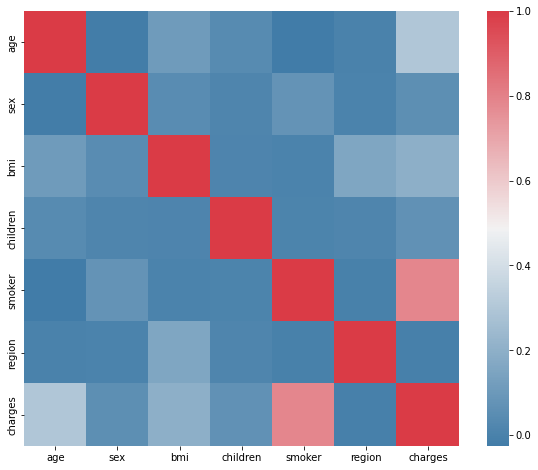

In [8]:
f, ax = pl.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True),
            square=True, ax=ax)

* charges와 강한 상관관계는 환자의 흡연 사실에서만 관찰됩니다.

smoker를 더 자세히 보겠습니다.

1) 먼저, charges의 분포를 살펴보겠습니다. 환자들이 평균적으로 치료에 얼마나 많은 돈을 쓰는지 알 수 있을 것입니다.

In [21]:
from bokeh.plotting import figure, output_notebook
from bokeh.io import show
import scipy.special
from bokeh.layouts import gridplot
output_notebook()

p = figure(title="Distribution of charges", tools="save",
            background_fill_color="#E8DDCB")
hist, edges = np.histogram(data.charges)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
p.xaxis.axis_label = 'x'
p.yaxis.axis_label = 'Pr(x)'
show(gridplot([p], ncols = 2, plot_width=400, plot_height=400, toolbar_location=None))

Text(0.5, 1.0, 'Distribution of charges for non-smokers')

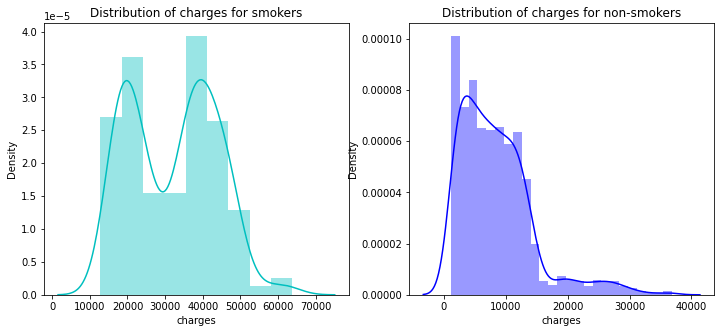

In [22]:
f= pl.figure(figsize=(12,5))

ax=f.add_subplot(121)
sns.distplot(data[(data.smoker == 1)]["charges"],color='c',ax=ax)
ax.set_title('Distribution of charges for smokers')

ax=f.add_subplot(122)
sns.distplot(data[(data.smoker == 0)]['charges'],color='b',ax=ax)
ax.set_title('Distribution of charges for non-smokers')

* 흡연 환자들은 치료에 더 많은 돈을 씁니다. 하지만 금연환자의 수가 더 많다는 느낌도 있습니다. 

확인해 보겠습니다.

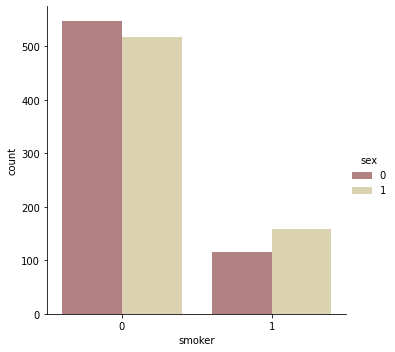

In [23]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="pink", data=data)

* 여성은 "1"(노란색), 남성은 "0"(붉은색)
* smoker==0인 금연자가 더 많습니다. 또한 여성 흡연자보다 남성 흡연자가 더 많다는 것을 알 수 있습니다. 

흡연의 영향을 고려할 때, 남성의 총 치료 비용은 여성보다 더 많을 것이라고 예상할 수 있습니다. 다른 시각화도 살펴보겠습니다.


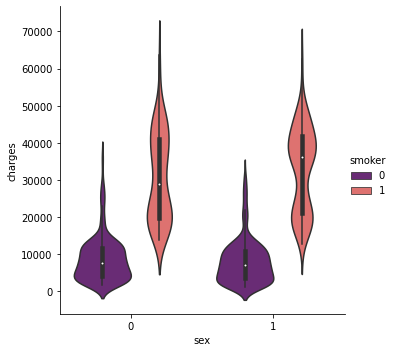

In [24]:
# violinplot
sns.catplot(x="sex", y="charges", hue="smoker",
            kind="violin", data=data, palette = 'magma')

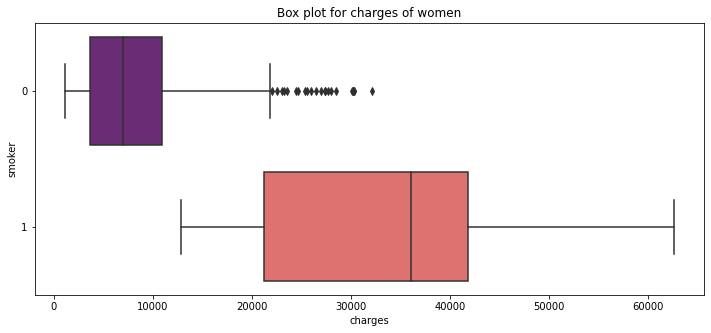

In [25]:
# boxplot 여성
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of women")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 1)] , orient="h", palette = 'magma')

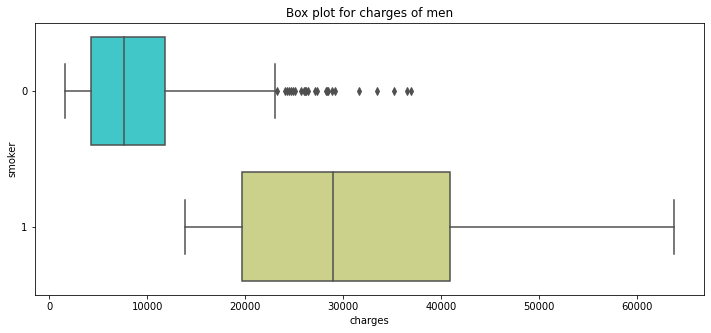

In [26]:
# boxplot 남성
pl.figure(figsize=(12,5))
pl.title("Box plot for charges of men")
sns.boxplot(y="smoker", x="charges", data =  data[(data.sex == 0)] , orient="h", palette = 'rainbow')

이제 환자의 연령에 대해 알아보겠습니다. 

먼저, 나이가 치료 비용에 어떤 영향을 미치는지 살펴보고, 데이터 집합에서 몇 살이 더 많은 환자인지도 살펴보겠습니다.


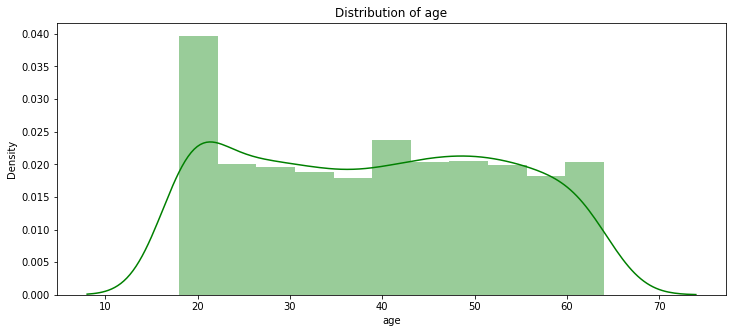

In [27]:
pl.figure(figsize=(12,5))
pl.title("Distribution of age")
ax = sns.distplot(data["age"], color = 'g')

데이터 세트에는 20세 미만의 환자가 있습니다. 18살은 환자의 최소 연령이고, 최대 나이는 64세입니다. 제 개인적인 관심은 18세 환자 중에 흡연자가 있는지 여부입니다.

Text(0.5, 1.0, 'The number of smokers and non-smokers (18 years old)')

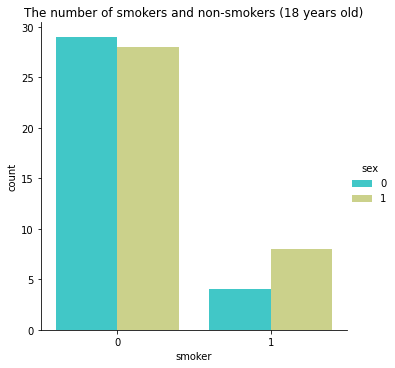

In [28]:
sns.catplot(x="smoker", kind="count",hue = 'sex', palette="rainbow", data=data[(data.age == 18)])
pl.title("The number of smokers and non-smokers (18 years old)")

18세 흡연은 이 나이 때의 치료비에 영향을 미칠지 살펴보겠습니다.

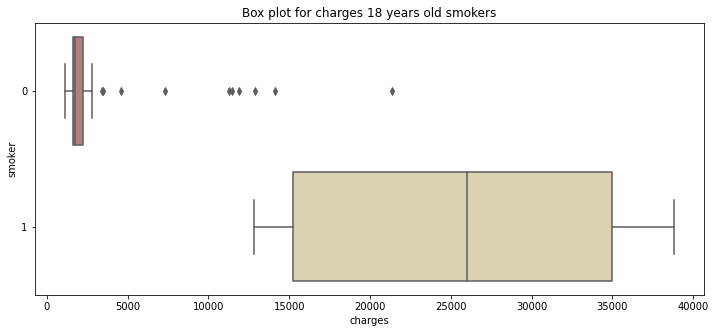

In [29]:
pl.figure(figsize=(12,5))
pl.title("Box plot for charges 18 years old smokers")
sns.boxplot(y="smoker", x="charges", data = data[(data.age == 18)] , orient="h", palette = 'pink')

18세의 흡연자라도 비흡연자보다 치료에 훨씬 더 많은 돈을 씁니다. 비흡연자들 사이에서 우리는 몇몇 "꼬리"를 보고 있습니다. 저는 이것이 심각한 질병이나 사고 때문이라고 추측할 수 있습니다. 

이제 치료비가 흡연자와 비흡연자의 나이에 따라 어떻게 달라지는지 알아보겠습니다.

Text(0.5, 1.0, 'Distribution of charges and age for non-smokers')

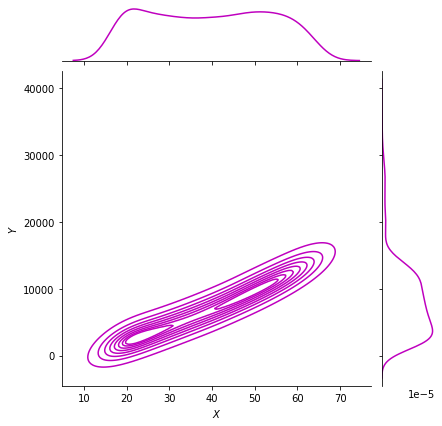

In [30]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 0)],kind="kde", color="m")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for non-smokers')

Text(0.5, 1.0, 'Distribution of charges and age for smokers')

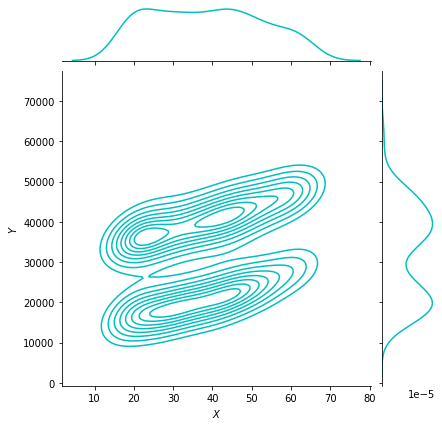

In [31]:
g = sns.jointplot(x="age", y="charges", data = data[(data.smoker == 1)],kind="kde", color="c")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of charges and age for smokers')

In [32]:
#non - smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 0)].age,y=data[(data.smoker == 0)].charges, size=7, line_color="navy", fill_color="pink", fill_alpha=0.9)

show(p)

In [33]:
#smokers
p = figure(plot_width=500, plot_height=450)
p.circle(x=data[(data.smoker == 1)].age,y=data[(data.smoker == 1)].charges, size=7, line_color="navy", fill_color="red", fill_alpha=0.9)
show(p)

Text(0.5, 1.0, 'Smokers and non-smokers')

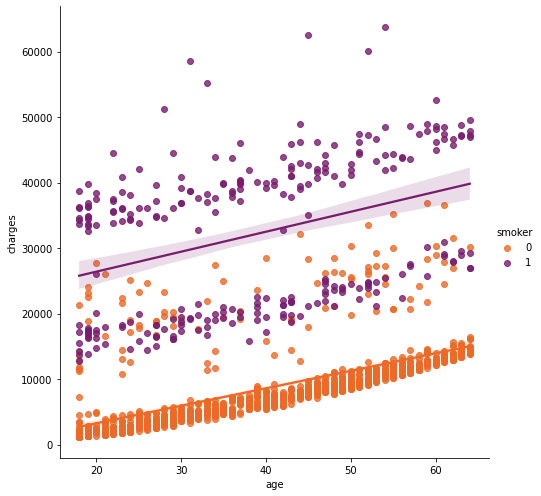

In [34]:
sns.lmplot(x="age", y="charges", hue="smoker", data=data, palette = 'inferno_r', size = 7)
ax.set_title('Smokers and non-smokers')

비흡연자의 경우 나이가 들수록 치료 비용이 증가합니다. 일리 있는 말이에요. 그러니 여러분, 건강을 돌봅시다!

흡연자들에게서 우리는 그런 의존성을 볼 수 없습니다. 저는 이것이 흡연뿐만 아니라 데이터 세트의 특성에도 있다고 생각합니다. 흡연이 치료 비용에 미치는 이러한 강력한 영향은 많은 수의 기록과 기호가 있는 일련의 데이터를 가지고 있다고 판단하는 것이 더 논리적일 것입니다. 

하지만 우리는 우리가 가진 것으로 일합니다! bmi에 주목해보면, 저는 이 수치가 환자의 치료비에 영향을 미친다는 사실에 놀랐습니다. 괜히 다이어트를 하는게 아니겠죠.


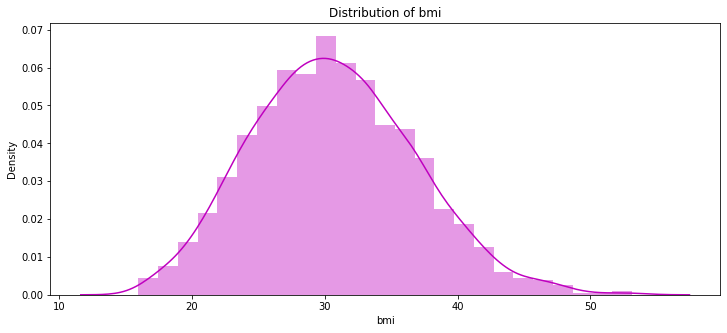

In [35]:
pl.figure(figsize=(12,5))
pl.title("Distribution of bmi")
ax = sns.distplot(data["bmi"], color = 'm')

환자의 평균 체질량지수는 30입니다. 

값이 30이면 비만이 시작되는데, 먼저 체질량지수(BMI)가 30 이상인 환자와 30 미만인 환자의 비용 분포를 살펴보겠습니다.

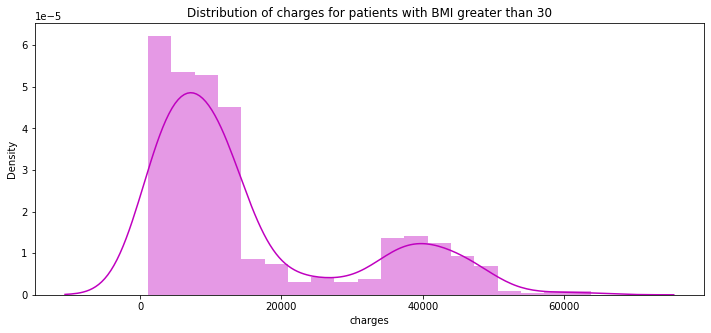

In [36]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI greater than 30")
ax = sns.distplot(data[(data.bmi >= 30)]['charges'], color = 'm')

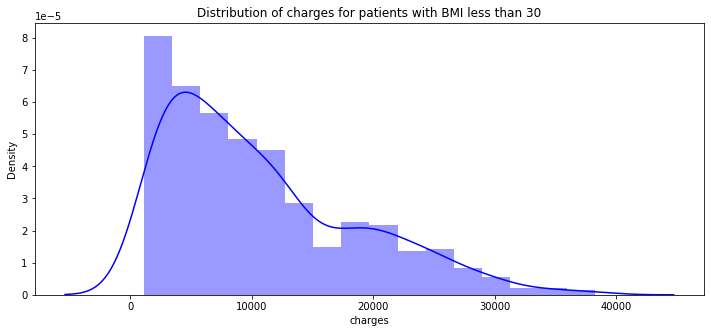

In [37]:
pl.figure(figsize=(12,5))
pl.title("Distribution of charges for patients with BMI less than 30")
ax = sns.distplot(data[(data.bmi < 30)]['charges'], color = 'b')

BMI가 30 이상인 환자들은 치료에 더 많은 돈을 씁니다!

Text(0.5, 1.0, 'Distribution of bmi and charges')

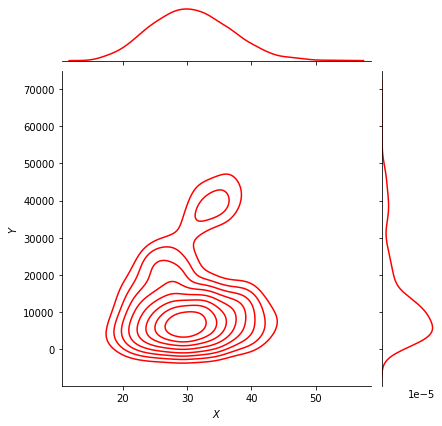

In [38]:
g = sns.jointplot(x="bmi", y="charges", data = data,kind="kde", color="r")
g.plot_joint(pl.scatter, c="w", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
ax.set_title('Distribution of bmi and charges')

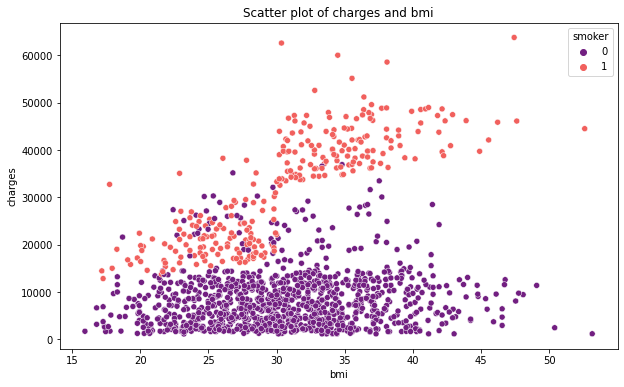

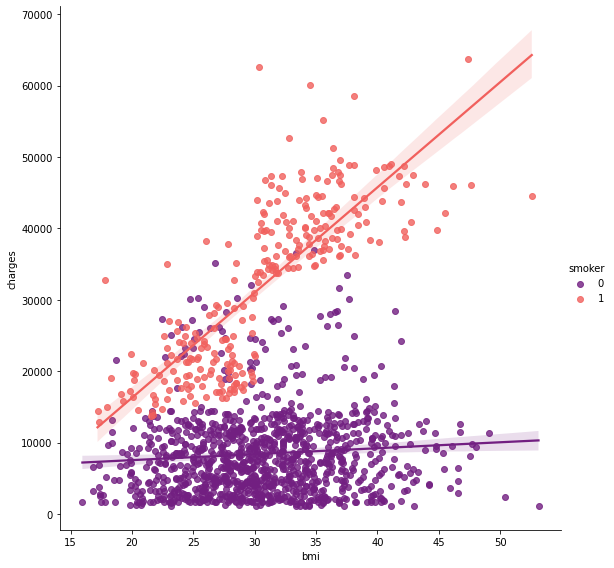

In [39]:
pl.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='charges',data=data,palette='magma',hue='smoker')
ax.set_title('Scatter plot of charges and bmi')

sns.lmplot(x="bmi", y="charges", hue="smoker", data=data, palette = 'magma', size = 8)

아이들에게 주목해 보면, 우선 우리 환자들이 얼마나 많은 아이를 가졌는지 알아보겠습니다.


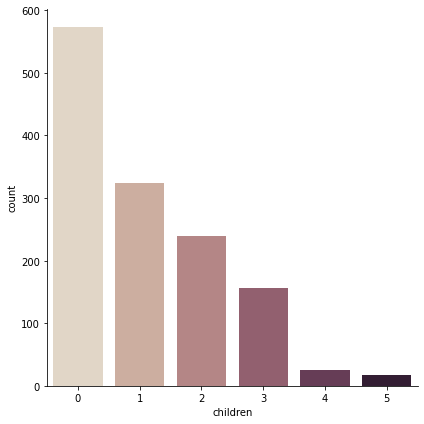

In [40]:
sns.catplot(x="children", kind="count", palette="ch:.25", data=data, size = 6)

대부분의 환자들은 아이가 없습니다. 어떤 사람들은 5명의 아이를 가지고 있습니다! 저는 아이를 가진 사람들이 담배를 피울지 궁금해요.


Text(0.5, 1.0, 'Smokers and non-smokers who have childrens')

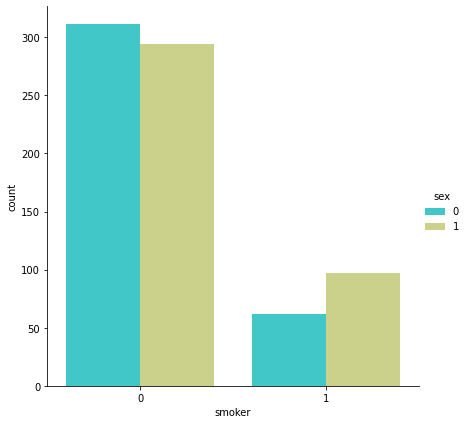

In [41]:
sns.catplot(x="smoker", kind="count", palette="rainbow",hue = "sex",
            data=data[(data.children > 0)], size = 6)
ax.set_title('Smokers and non-smokers who have childrens')

아.. 하지만 저는 금연하는 부모들이 훨씬 더 많다는 것이 기쁩니다!

이 데이터셋을 탐색하기 위한 몇 가지 아이디어가 더 있는데, 이제 치료 비용을 예측해 보겠습니다. 일반적인 선형 회귀 분석부터 시작하겠습니다.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [43]:
x = data.drop(['charges'], axis = 1)
y = data.charges

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0)
lr = LinearRegression().fit(x_train,y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print(lr.score(x_test,y_test))

0.7962732059725786


데이터 정규화가 없어도 이러한 느린 구현에는 나쁘지 않습니다. 결국, 데이터가 항상 좋은 것만은 아니다. 따라서 데이터를 사전 처리하는 것을 잊지 마십시오.

이제 다항식 부호를 추가합시다. 그리고 결과를 보세요.


In [44]:
X = data.drop(['charges','region'], axis = 1)
Y = data.charges


quad = PolynomialFeatures (degree = 2)
x_quad = quad.fit_transform(X)

X_train,X_test,Y_train,Y_test = train_test_split(x_quad,Y, random_state = 0)

plr = LinearRegression().fit(X_train,Y_train)

Y_train_pred = plr.predict(X_train)
Y_test_pred = plr.predict(X_test)

print(plr.score(X_test,Y_test))

0.8849197344147228


이미 우리 모델은 환자의 치료 비용을 잘 예측합니다. 저는 우리가 두, 세 개의 다항식 특징을 만드는 것에 국한할 수 있다고 생각합니다. 하지만 데이터 세트가 너무 작아서 우리는 쉬운 길을 택했습니다.

마지막으로 RandomForestRegressor를 사용해 보십시오.

In [45]:
forest = RandomForestRegressor(n_estimators = 100,
                              criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
forest.fit(x_train,y_train)
forest_train_pred = forest.predict(x_train)
forest_test_pred = forest.predict(x_test)

print('MSE train data: %.3f, MSE test data: %.3f' % (
mean_squared_error(y_train,forest_train_pred),
mean_squared_error(y_test,forest_test_pred)))
print('R2 train data: %.3f, R2 test data: %.3f' % (
r2_score(y_train,forest_train_pred),
r2_score(y_test,forest_test_pred)))

MSE train data: 3729086.094, MSE test data: 19933823.142
R2 train data: 0.974, R2 test data: 0.873


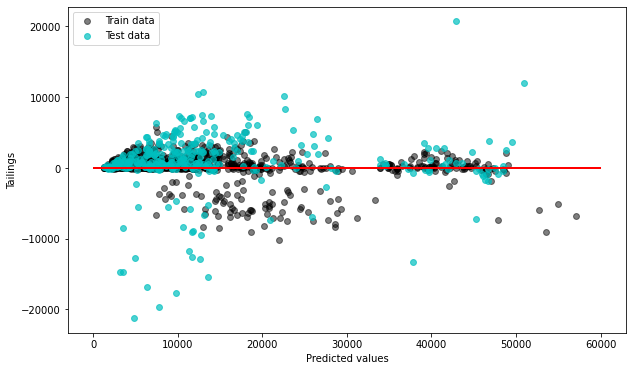

In [46]:
pl.figure(figsize=(10,6))

pl.scatter(forest_train_pred,forest_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
pl.scatter(forest_test_pred,forest_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.7,
          label = 'Test data')
pl.xlabel('Predicted values')
pl.ylabel('Tailings')
pl.legend(loc = 'upper left')
pl.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')
pl.show()

좋은 결과입니다. 하지만 우리는 훈련 데이터에서 알고리즘의 눈에 띄는 retraining을 볼 수 있습니다.